## 1) Сбор данных:

In [66]:
import os
import pandas as pd

data_folder = '/Users/maximdemekhin/Downloads/ML/milk/csv_ivium_new_data'

voltage = pd.read_csv('/Users/maximdemekhin/Downloads/ML/milk/csv_ivium_new_data/milk/milk_0.0_227.csv')['Voltage, V'].tolist()

columns = voltage + ['Antibiotic', 'Concentration'] 
rows = []

for antibiotic in os.listdir(data_folder):
    antibiotic_path = os.path.join(data_folder, antibiotic)

    if not os.path.isdir(antibiotic_path):
        continue

    for file in os.listdir(antibiotic_path):
        if not file.endswith('.csv'):
            continue

        file_path = os.path.join(antibiotic_path, file)
        concentration = file.split('_')[1]

        df = pd.read_csv(file_path)
        current = df.iloc[:, 2].tolist()

        new_row = current + [antibiotic, concentration]
        rows.append(new_row)

df_final = pd.DataFrame(rows, columns = columns)

df_final.to_csv('/Users/maximdemekhin/Downloads/ML/milk/result.csv')

## 2) Анализ базы данных:

### 2.1 Определение диапазона концентраций + построение гистограммы распредения числа измерений для каждого

cefazoline [1e-06; 1e-10]
ceftiofur [1e-06; 1e-10]
milk [0.0; 0.0]
penicillin [1e-07; 1e-11]
streptomycin [1e-05; 1e-09]
tetracycline [1e-06; 1e-10]


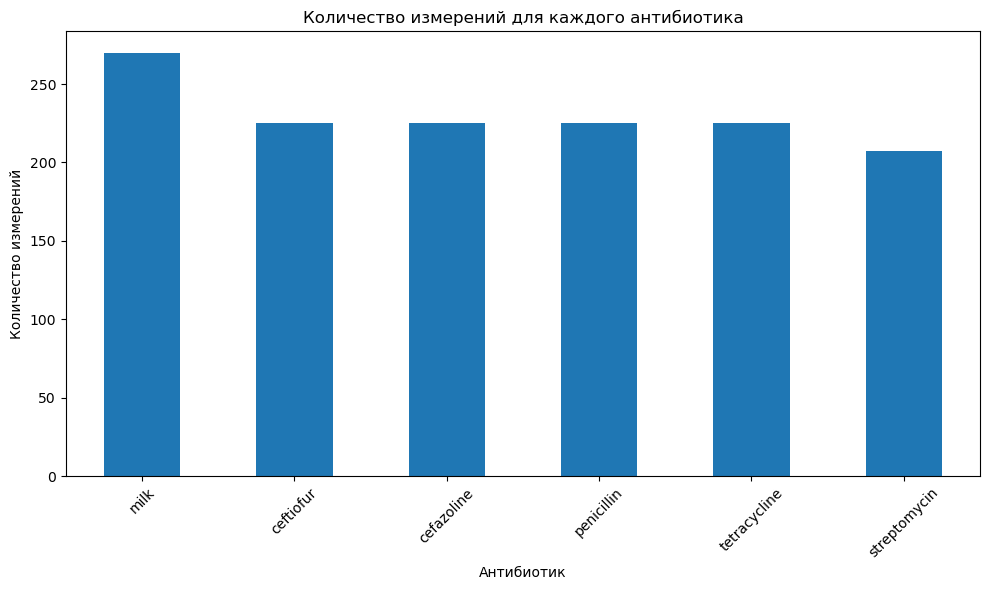

In [67]:
import matplotlib.pyplot as plt

antibiotics = df_final['Antibiotic'].unique()

concentration_ranges = {}

for antibiotic in antibiotics:
    concentrations = df_final[df_final['Antibiotic'] == antibiotic]['Concentration']
    concentration_ranges[antibiotic] = [concentrations.min(), concentrations.max()]

for antibiotic in sorted(concentration_ranges):
    min_conc, max_conc = concentration_ranges[antibiotic]
    print(f'{antibiotic} [{min_conc}; {max_conc}]')

plt.figure(figsize = (10, 6))
measure_counts = df_final['Antibiotic'].value_counts()
measure_counts.plot(kind='bar')
plt.title('Количество измерений для каждого антибиотика')
plt.xlabel('Антибиотик')
plt.ylabel('Количество измерений')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

### 2.2 Построение вольтамперограмм

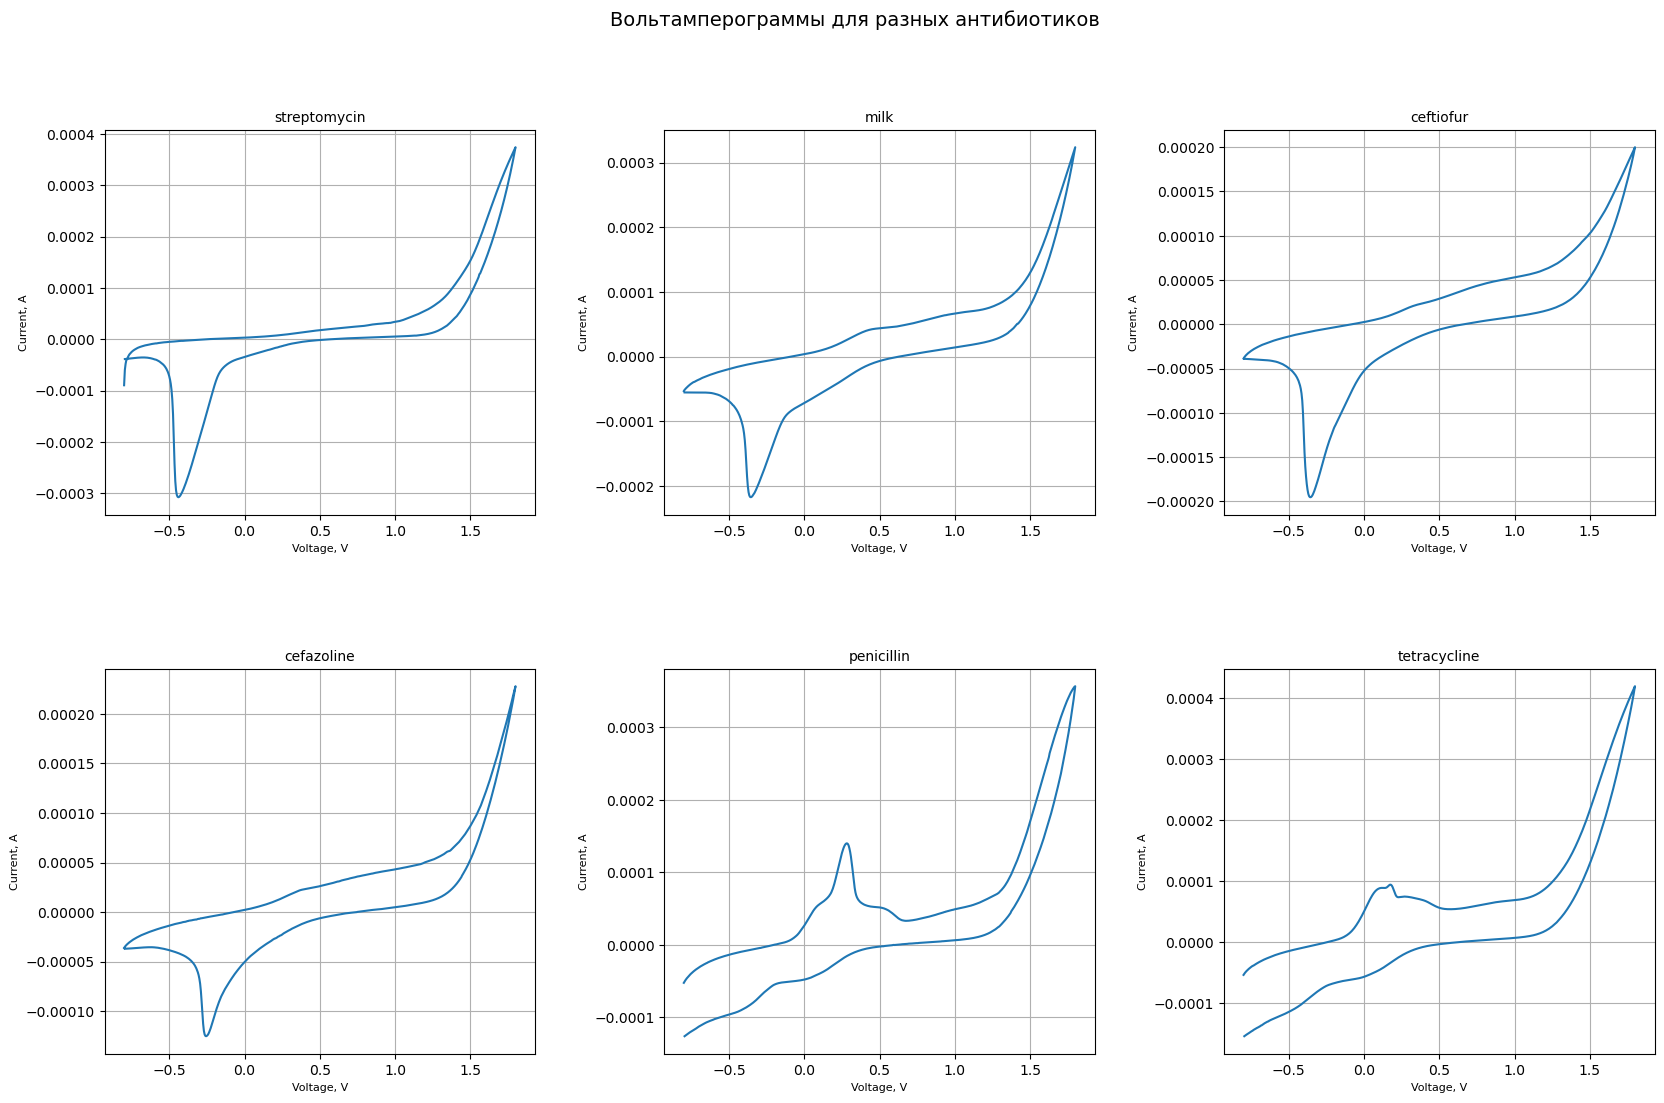

In [68]:
voltage = pd.read_csv('/Users/maximdemekhin/Downloads/ML/milk/csv_ivium_new_data/milk/milk_0.0_227.csv')['Voltage, V'].tolist()

x_values = voltage

fig, axes = plt.subplots(2, 3, figsize = (20, 12))
plt.subplots_adjust(wspace = 0.3, hspace = 0.4)

for idx, antibiotic in enumerate(df_final['Antibiotic'].unique()):

    row = df_final[df_final['Antibiotic'] == antibiotic].iloc[0]

    y_values = row.iloc[:-2].astype(float).values

    ax = axes[idx // 3, idx % 3]
    ax.plot(x_values, y_values)
    ax.set_title(antibiotic, fontsize=10)
    ax.set_xlabel('Voltage, V', fontsize=8)
    ax.set_ylabel('Current, A', fontsize=8)
    ax.grid(True)

plt.suptitle('Вольтамперограммы для разных антибиотиков', fontsize=14)
plt.show()

## 3) Обучение моделей бинарной классификации

### Создание метки

In [69]:
df_final['target'] = df_final['Antibiotic'].apply(lambda x: 0 if x == 'milk' else 1)

### Разделение на обучающую и тестовую выборки и нормализация 'Иксов'

In [70]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Разделение на признаки и целевую переменную
X = df_final.iloc[:, :-3]
y = df_final.iloc[:, -1]

# Нормализация признаков
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

### Импорт библиотек и определение функций для оценки моделей

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix

In [72]:
# Предсказание на тестовых данных

def predict_model(model, X_test):
    """
    Предсказывает метки и вероятности для тестового набора данных с помощью обученной модели.
    
    Параметры:
    model : обученная модель, поддерживающая методы predict и predict_proba
    X_test : тестовые данные

    Возвращает:
    y_pred : предсказанные метки
    y_proba : предсказанные вероятности для положительного класса
    """
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    return y_pred, y_proba

In [73]:
# Вычисление и вывод метрик

def evaluate_metrics(y_test, y_pred, y_proba):
    """
    Вычисляет и выводит метрики модели: Accuracy, Recall, F1-мера и AUC.

    Параметры:
    y_test : истинные метки тестовых данных
    y_pred : предсказанные метки
    y_proba : предсказанные вероятности для положительного класса
    """
    acc = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    print(f"Accuracy: {acc:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-мера: {f1:.4f}")
    print(f"AUC: {auc:.4f}")

In [74]:
# Построение ROC-кривой

def plot_roc_curve(y_test, y_proba):
    """
    Строит ROC-кривую для модели.

    Параметры:
    y_test : истинные метки тестовых данных
    y_proba : предсказанные вероятности для положительного класса
    """
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label = f'ROC-кривая (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle = '--', color = 'grey')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC-кривая')
    plt.legend()
    plt.grid(True)
    plt.show()

In [75]:
# Построение матрицы ошибок

def plot_confusion_matrix(y_test, y_pred):
    """
    Строит матрицу ошибок.
    
    Параметры:
    y_test : истинные метки тестовых данных
    y_pred : предсказанные вероятности для положительного класса
    """
    cm = confusion_matrix(y_test, y_pred)
    print("Матрица ошибок:")
    print(cm)
    
    #Подпись к осям
    class_labels = ['Milk', 'Not milk']

    plt.figure(figsize = (8, 6))
    sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_labels, yticklabels = class_labels)
    plt.xlabel('Предсказанные метки')
    plt.ylabel('Истинные метки')
    plt.title('Матрица ошибок')
    plt.show()

## 1. Логистическая регрессия

Accuracy: 0.8949
Recall: 0.9726
F1-мера: 0.9363
AUC: 0.9309


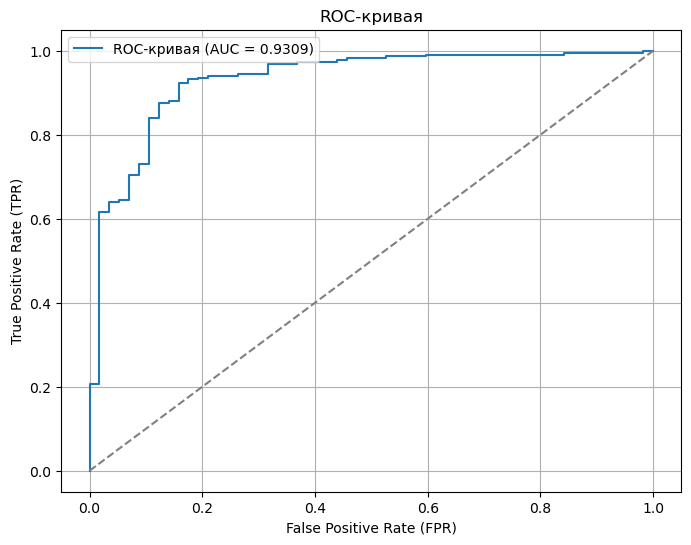

In [76]:
from sklearn.linear_model import LogisticRegression

# Обучение модели
model = LogisticRegression(
    random_state = 42,  # Для воспроизводимости
    max_iter = 1000
)
model.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred, y_proba = predict_model(model, X_test)

# Вычисление и вывод метрик
evaluate_metrics(y_test, y_pred, y_proba)

# Построение ROC-кривой
plot_roc_curve(y_test, y_proba)

## 2. k-ближайших соседей (k-NN)

Accuracy: 0.9710
Recall: 1.0000
F1-мера: 0.9821
AUC: 0.9866


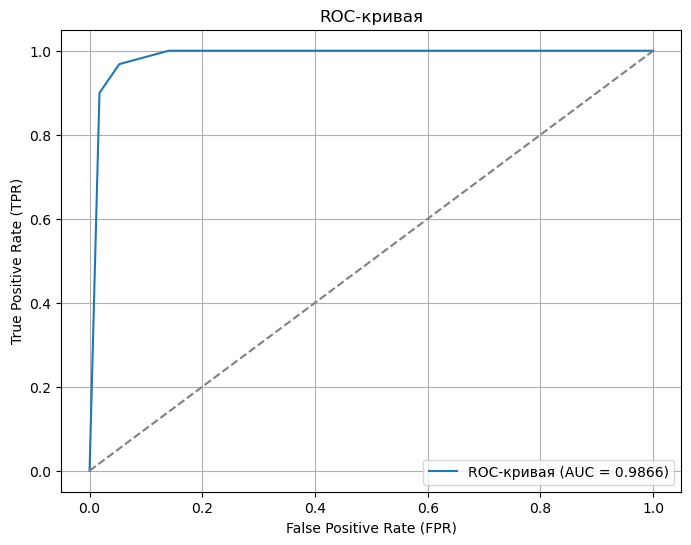

In [77]:
from sklearn.neighbors import KNeighborsClassifier

# Обучение модели
model = KNeighborsClassifier(n_neighbors = 5)  # По умолчанию 5 соседей
model.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred, y_proba = predict_model(model, X_test)

# Вычисление и вывод метрик
evaluate_metrics(y_test, y_pred, y_proba)

# Построение ROC-кривой
plot_roc_curve(y_test, y_proba)

### Подбор параметров с помощью GridSearchCV

In [78]:
from sklearn.model_selection import GridSearchCV

model = KNeighborsClassifier()

# Сетка параметров
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'euclidean', 'manhattan', 'chebyshev']
}

# Запуск GridSearchCV
grid_search = GridSearchCV(model, param_grid, 
                           cv = 5, # cross-validation (по умолчанию 5), на сколько частей разбивается выборка, чем больше, тем лучше, но по времени дольше
                           scoring='accuracy', 
                           n_jobs = -1 # использовать все ядра процессора
                           ) 

grid_search.fit(X_train, y_train)

print("Лучшие параметры для k-NN:", grid_search.best_params_)

Лучшие параметры для k-NN: {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}


### Обучение модели с этими параметрами:

Accuracy: 0.9819
Recall: 0.9954
F1-мера: 0.9887
AUC: 0.9626


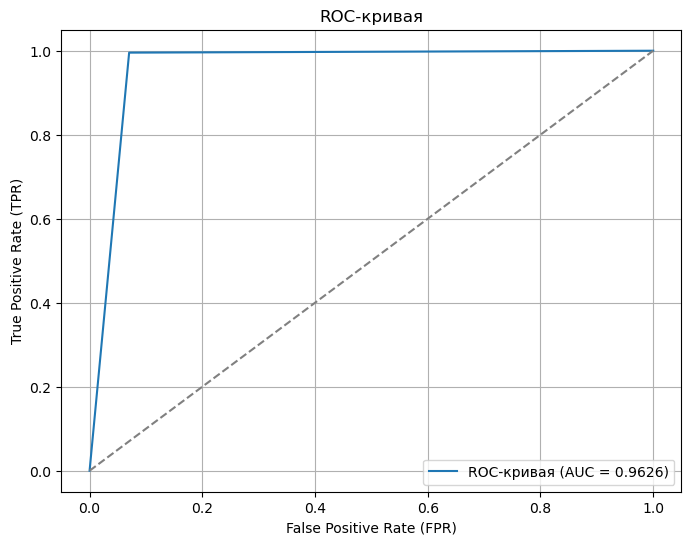

In [79]:
from sklearn.neighbors import KNeighborsClassifier

# Обучение модели
model = KNeighborsClassifier(**grid_search.best_params_)
model.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred, y_proba = predict_model(model, X_test)

# Вычисление и вывод метрик
evaluate_metrics(y_test, y_pred, y_proba)

# Построение ROC-кривой
plot_roc_curve(y_test, y_proba)

Ну accuracy, конечно, увеличилось, так как GridSearchCV был настроен как раз на это (scoring='accuracy'), но AUC и Recall просели.

В общем, мне было интересно узнать про подбор параметров, поэтому я провел такой небольшой эксперимент

## 3. Случайный лес (Random Forest)

Accuracy: 0.9638
Recall: 0.9817
F1-мера: 0.9773
AUC: 0.9928


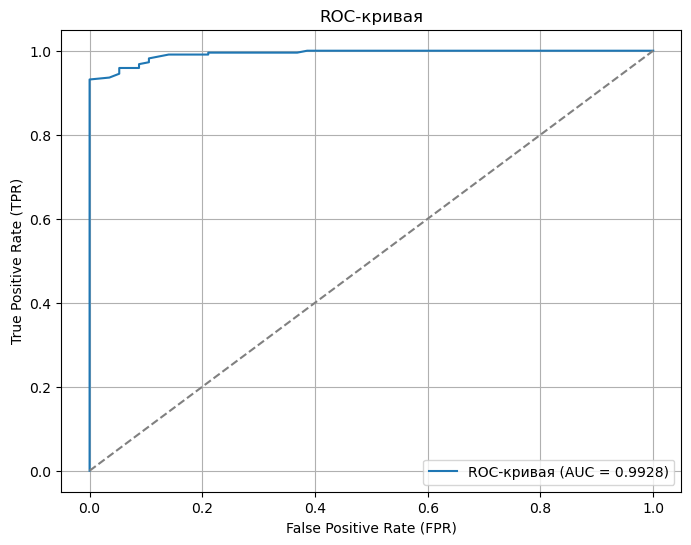

In [80]:
from sklearn.ensemble import RandomForestClassifier

# Обучение модели
model = RandomForestClassifier(
    n_estimators = 50,  # Количество деревьев 
    random_state = 42,    # Для воспроизводимости
    max_depth = 50      # Максимальная глубина деревьев
)
model.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred, y_proba = predict_model(model, X_test)

# Вычисление и вывод метрик
evaluate_metrics(y_test, y_pred, y_proba)

# Построение ROC-кривой
plot_roc_curve(y_test, y_proba)

Accuracy: 0.9710
Recall: 0.9863
F1-мера: 0.9818
AUC: 0.9950


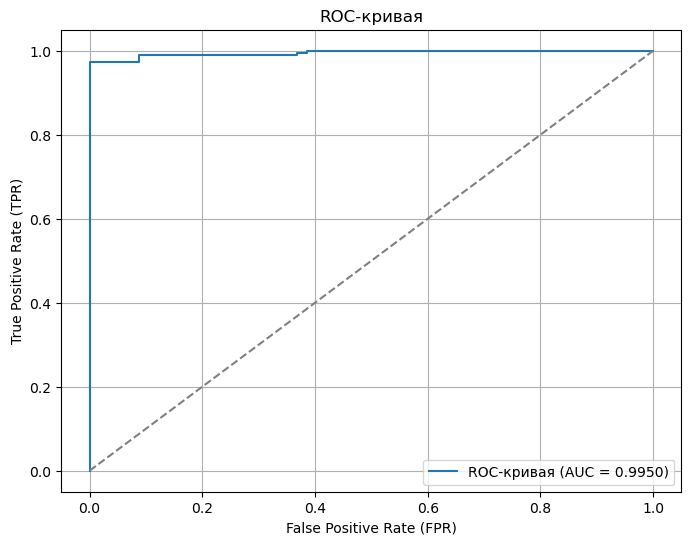

In [81]:
from sklearn.ensemble import RandomForestClassifier

# Обучение модели
model = RandomForestClassifier(
    n_estimators = 500,  # Количество деревьев 
    random_state = 42,    # Для воспроизводимости
    max_depth = 500      # Максимальная глубина деревьев
)
model.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred, y_proba = predict_model(model, X_test)

# Вычисление и вывод метрик
evaluate_metrics(y_test, y_pred, y_proba)

# Построение ROC-кривой
plot_roc_curve(y_test, y_proba)

Accuracy: 0.9746
Recall: 0.9909
F1-мера: 0.9841
AUC: 0.9949


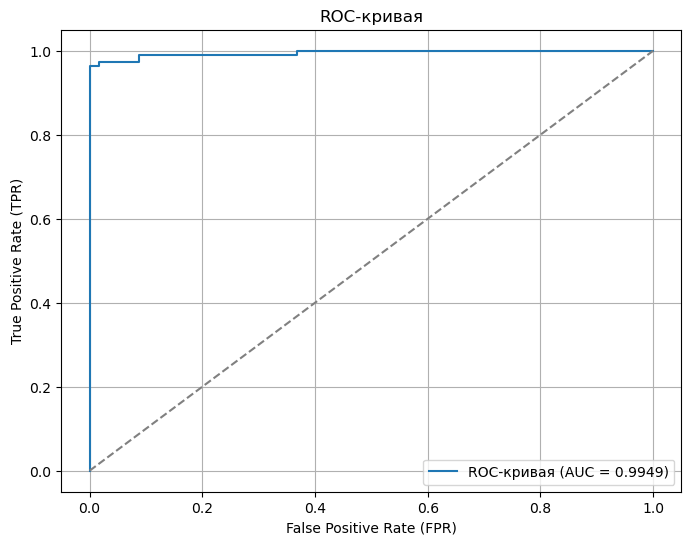

In [82]:
from sklearn.ensemble import RandomForestClassifier

# Обучение модели
model = RandomForestClassifier(
    n_estimators = 5000,  # Количество деревьев
    random_state = 42,    # Для воспроизводимости
    max_depth = 5000      # Максимальная глубина деревьев
)
model.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred, y_proba = predict_model(model, X_test)

# Вычисление и вывод метрик
evaluate_metrics(y_test, y_pred, y_proba)

# Построение ROC-кривой
plot_roc_curve(y_test, y_proba)

## 4. Метод опорных векторов (SVM)

Accuracy: 0.8877
Recall: 0.9863
F1-мера: 0.9330
AUC: 0.9298


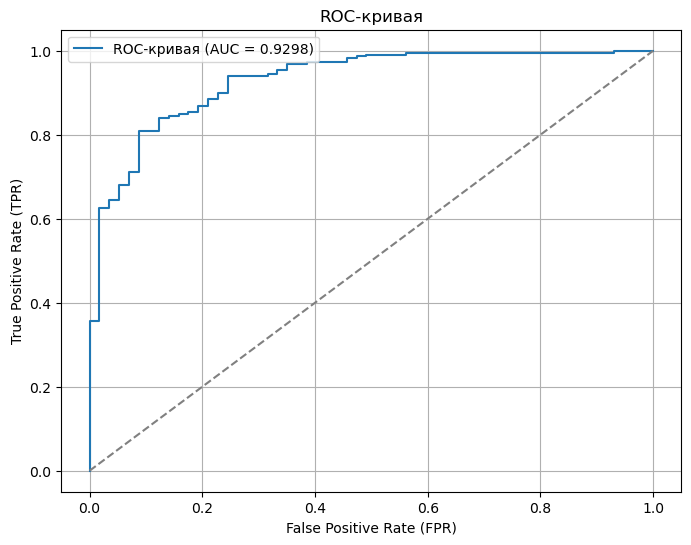

In [83]:
from sklearn.svm import SVC

# Обучение модели
model = SVC(
    kernel ='rbf',           # 'rbf' (по умолчанию), 'linear', 'poly', 'sigmoid'
    probability = True,      # Включаем расчет вероятностей для ROC-кривой
    random_state = 42,       # Для воспроизводимости
    C = 1.0                  # Параметр регуляризации
)
model.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred, y_proba = predict_model(model, X_test)

# Вычисление и вывод метрик
evaluate_metrics(y_test, y_pred, y_proba)

# Построение ROC-кривой
plot_roc_curve(y_test, y_proba)

### Подбор параметров с помощью RandomizedSearchCV

In [84]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

model = SVC(random_state=42)

# Сетка параметров
param_dist = {
    'C': uniform(0.1, 100),  # Параметр регуляризации
    'kernel': ['linear', 'rbf', 'poly'],  # Тип ядра
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 1, 5)),  # Коэффициент для ядра
    'degree': [2, 3, 4],  # Степень полиномиального ядра
    'coef0': uniform(0.0, 1.0),  # Независимый член
    'class_weight': [None, 'balanced']  # Веса классов
}

# Запуск RandomizedSearchCV
random_search = RandomizedSearchCV( model, param_dist, n_iter = 50, cv = 5, scoring = 'accuracy', random_state = 42, n_jobs = -1)

random_search.fit(X_train, y_train)

print("Лучшие параметры:", random_search.best_params_)

Лучшие параметры: {'C': np.float64(2.1584494295802448), 'class_weight': 'balanced', 'coef0': np.float64(0.7219987722668247), 'degree': 3, 'gamma': np.float64(1.0), 'kernel': 'rbf'}


### Обучение модели с этими параметрами:

Accuracy: 0.9819
Recall: 1.0000
F1-мера: 0.9887
AUC: 0.9966


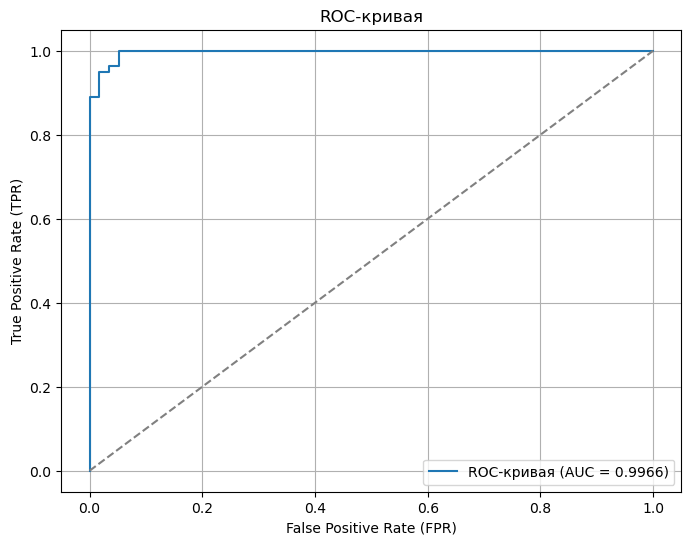

In [85]:
from sklearn.svm import SVC

# Обучение модели
model = SVC(**random_search.best_params_, probability = True, random_state = 42)
model.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred, y_proba = predict_model(model, X_test)

# Вычисление и вывод метрик
evaluate_metrics(y_test, y_pred, y_proba)

# Построение ROC-кривой
plot_roc_curve(y_test, y_proba)

В данном случае подбор параметров с помощью RandomizedSearchCV показывает прям очень хорошие результаты, существенно увеличивая значения всех метрик

## 5. Градиентный бустинг (Gradient Boost)

Accuracy: 0.9384
Recall: 0.9772
F1-мера: 0.9618
AUC: 0.9479


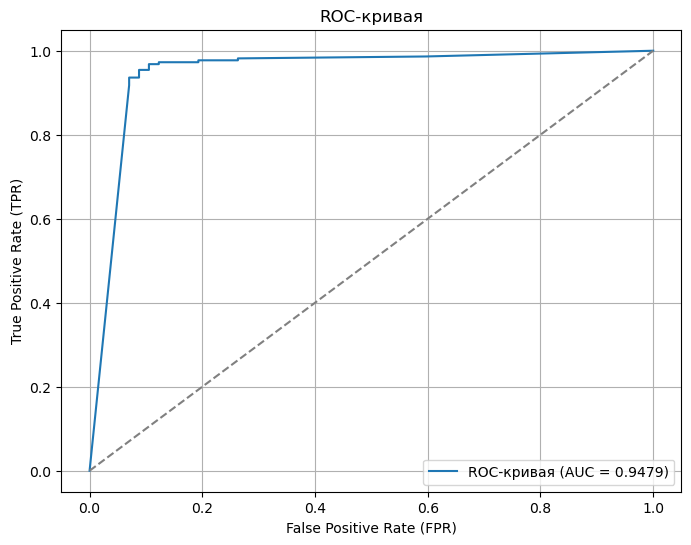

In [86]:
from sklearn.ensemble import GradientBoostingClassifier

# Обучение модели
model = GradientBoostingClassifier(
    random_state = 42,  # Для воспроизводимости
    n_estimators = 10,  # Количество деревьев
    learning_rate = 0.1,  # Скорость обучения
    max_depth = 10  # Максимальная глубина деревьев
)
model.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred, y_proba = predict_model(model, X_test)

# Вычисление и вывод метрик
evaluate_metrics(y_test, y_pred, y_proba)

# Построение ROC-кривой
plot_roc_curve(y_test, y_proba)

Accuracy: 0.9493
Recall: 0.9726
F1-мера: 0.9682
AUC: 0.9692


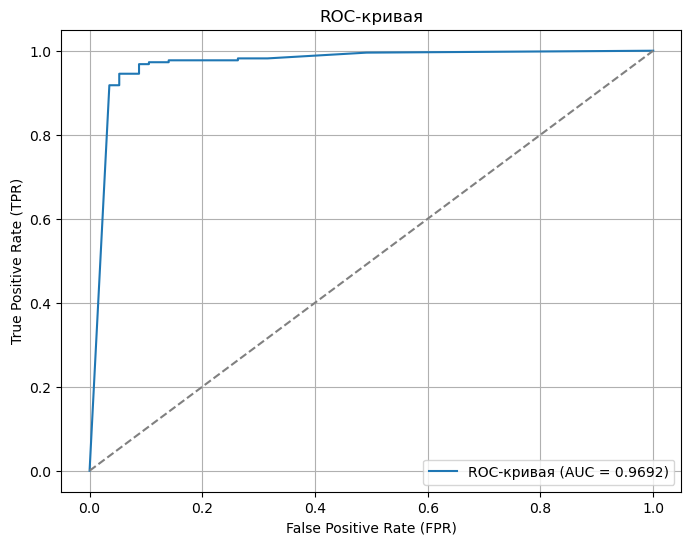

In [87]:
from sklearn.ensemble import GradientBoostingClassifier

# Обучение модели
model = GradientBoostingClassifier(
    random_state = 42,  # Для воспроизводимости
    n_estimators = 20,  # Количество деревьев
    learning_rate = 0.1,  # Скорость обучения
    max_depth = 20  # Максимальная глубина деревьев
)
model.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred, y_proba = predict_model(model, X_test)

# Вычисление и вывод метрик
evaluate_metrics(y_test, y_pred, y_proba)

# Построение ROC-кривой
plot_roc_curve(y_test, y_proba)

Accuracy: 0.9529
Recall: 0.9726
F1-мера: 0.9704
AUC: 0.9660


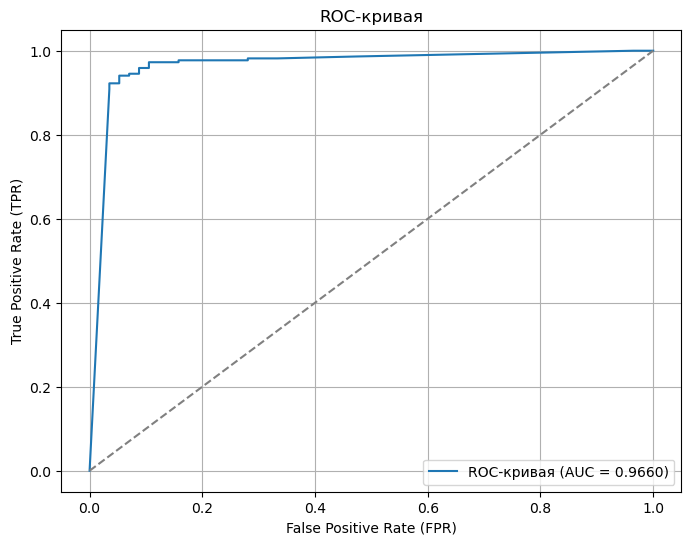

In [88]:
from sklearn.ensemble import GradientBoostingClassifier

# Обучение модели
model = GradientBoostingClassifier(
    random_state = 42,  # Для воспроизводимости
    n_estimators = 50,  # Количество деревьев
    learning_rate = 0.1,  # Скорость обучения
    max_depth = 50  # Максимальная глубина деревьев
)
model.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred, y_proba = predict_model(model, X_test)

# Вычисление и вывод метрик
evaluate_metrics(y_test, y_pred, y_proba)

# Построение ROC-кривой
plot_roc_curve(y_test, y_proba)

## Построение матрицы ошибок для модели с наибольшей точностью

Лучше всего по всем метрикам показала себя модель SVM после оптимизации параметров с помощью RandomizedSearchCV, соответственно построим для этой модели матрицу ошибок:

Матрица ошибок:
[[ 52   5]
 [  0 219]]


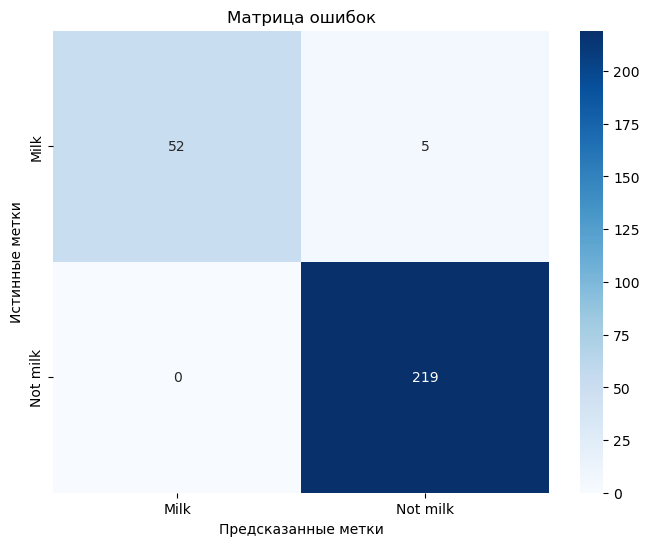

In [89]:
from sklearn.svm import SVC

# Обучение модели
model = SVC(**random_search.best_params_, probability = True, random_state = 42)
model.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred, y_proba = predict_model(model, X_test)

# Построение матрицы ошибок
plot_confusion_matrix(y_test, y_pred)

### Отрисовка матрицы с помощью инструмента scikitplot

In [90]:
import scikitplot as skplt

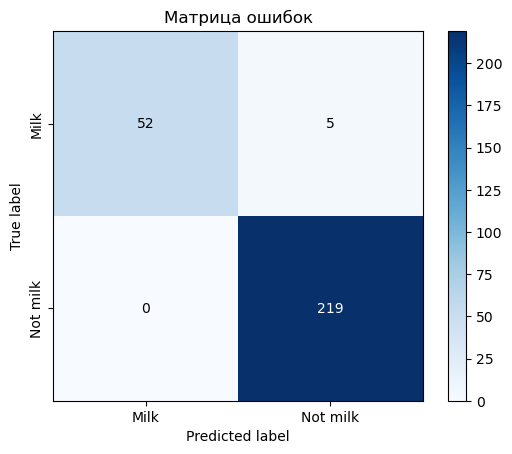

In [91]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred)

#Подпись к осям
ax = plt.gca()
ax.set_xticklabels(['Milk', 'Not milk'])
ax.set_yticklabels(['Milk', 'Not milk'], rotation = 90, va = 'center')

plt.title('Матрица ошибок')
plt.show()

## 4) Обучение моделей классификации на много классов

### Создание метки

In [92]:
df_final = df_final.drop(columns = 'target')

In [93]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df_final['target'] = le.fit_transform(df_final['Antibiotic'])

In [94]:
# Как были закодированы значения
map = dict(zip(le.classes_, range(len(le.classes_))))
print("Сопоставление значений и числовых меток:")
print(map)

Сопоставление значений и числовых меток:
{'cefazoline': 0, 'ceftiofur': 1, 'milk': 2, 'penicillin': 3, 'streptomycin': 4, 'tetracycline': 5}


### Разделение на обучающую и тестовую выборки и нормализация 'Иксов'

In [95]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Разделение на признаки и целевую переменную
X = df_final.iloc[:, :-3]
y = df_final.iloc[:, -1]

# Нормализация признаков
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

### Переопределение функций для вычисления и вывода меток

Так как для в случае классификации на много классов для моделей нерелевантна метрика AUC, а соответственно и ROC-кривая, нужно немного изменить подход, использовавшийся раньше

In [96]:
# Вычисление и вывод метрик

def evaluate_metrics(y_test, y_pred, y_proba):
    """
    Вычисляет и выводит метрики модели: Accuracy, Recall и F1-мера.

    Параметры:
    y_test : истинные метки тестовых данных
    y_pred : предсказанные метки
    y_proba : предсказанные вероятности для положительного класса
    """
    acc = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Accuracy: {acc:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-мера: {f1:.4f}")

Определим функцию для построения матрицы ошибок с использованием scikitplot

In [97]:
# Построение матрицы ошибок

def plot_scikitplot_confusion_matrix(y_test, y_pred):
    """
    Строит матрицу ошибок с использованием scikit-plot.

    Параметры:
    y_test : истинные метки тестовых данных
    y_pred : предсказанные метки
    """
    skplt.metrics.plot_confusion_matrix(y_test, y_pred)

    #Подпись к осям
    ax = plt.gca()
    labels = ['cefazoline', 'ceftiofur', 'milk', 'penicillin', 'streptomycin', 'tetracycline']
    ax.set_xticklabels(labels, rotation = 45)
    ax.set_yticklabels(labels, rotation = 45, va = 'center')

    plt.title('Матрица ошибок')
    plt.show()

## 1. Логистическая регрессия

In [98]:
# Обучение модели
model = LogisticRegression(
    random_state = 42,  # Для воспроизводимости
    max_iter = 1000
)
model.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred, y_proba = predict_model(model, X_test)

# Вычисление и вывод метрик
evaluate_metrics(y_test, y_pred, y_proba)


Accuracy: 0.7899
Recall: 0.7899
F1-мера: 0.7901


## 2. k-NN

In [99]:
# Обучение модели
model = KNeighborsClassifier(metric = 'manhattan', n_neighbors = 1, weights = 'uniform')
model.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred, y_proba = predict_model(model, X_test)

# Вычисление и вывод метрик
evaluate_metrics(y_test, y_pred, y_proba)

Accuracy: 0.8804
Recall: 0.8804
F1-мера: 0.8814


## 3. Random Forest

In [100]:
# Обучение модели
model = RandomForestClassifier(
    n_estimators = 5000,  # Количество деревьев
    random_state = 42,    # Для воспроизводимости
    max_depth = 5000      # Максимальная глубина деревьев
)
model.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred, y_proba = predict_model(model, X_test)

# Вычисление и вывод метрик
evaluate_metrics(y_test, y_pred, y_proba)

Accuracy: 0.8949
Recall: 0.8949
F1-мера: 0.8949


## 4. SVM

In [101]:
# Обучение модели
model = SVC(
    C = np.float64(2.1584494295802448), 
    class_weight = 'balanced', 
    coef0 = np.float64(0.7219987722668247), 
    degree = 3, 
    gamma = np.float64(1.0), 
    kernel = 'rbf',
    probability = True,
    random_state = 42,
)
model.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred, y_proba = predict_model(model, X_test)

# Вычисление и вывод метрик
evaluate_metrics(y_test, y_pred, y_proba)

Accuracy: 0.8696
Recall: 0.8696
F1-мера: 0.8705


## 5. Gradient Boosting

In [102]:
# Обучение модели
model = GradientBoostingClassifier(
    random_state = 42,  # Для воспроизводимости
    n_estimators = 10,  # Количество деревьев
    learning_rate = 0.1,  # Скорость обучения
    max_depth = 10  # Максимальная глубина деревьев
)
model.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred, y_proba = predict_model(model, X_test)

# Вычисление и вывод метрик
evaluate_metrics(y_test, y_pred, y_proba)

Accuracy: 0.8261
Recall: 0.8261
F1-мера: 0.8272


## Построение матрицы ошибок для модели с наибольшей точностью

Лучше всего получился Random Forest, построим для этой модели матрицу ошибок:

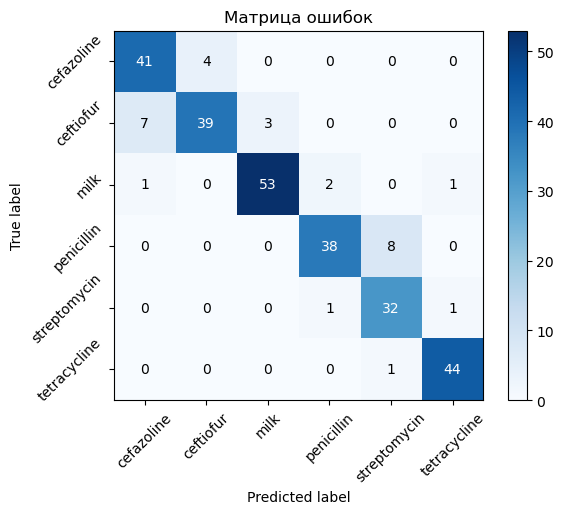

In [103]:
# Обучение модели
model = RandomForestClassifier(
    n_estimators = 5000,  # Количество деревьев
    random_state = 42,    # Для воспроизводимости
    max_depth = 5000      # Максимальная глубина деревьев
)
model.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred, y_proba = predict_model(model, X_test)

# Построение матрицы ошибок
plot_scikitplot_confusion_matrix(y_test, y_pred)